In [1]:
%store -r

In [2]:
import os
import pathlib
from glob import glob
from math import floor, ceil

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import xrspatial

c:\Users\tjsto\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fit a model: For each forest:

    Download model variables as raster layers covering your study area envelope, including:
        At least one soil variable from the POLARIS dataset
        Elevation from the SRTM (available from the earthaccess API)
        At least one climate variable from the MACAv2 THREDDS data server. Your project should compare two climate scenarios of your choice (e.g. different time periods, different emission scenarios). You can find a tutorial on how to access these climate data on earthdatascience.org


In [27]:
def polaris_soil_data(variable, statistic, depth, gdf):
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
                "/{variable}"
                "/{statistic}"
                "/{depth}"
                "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif")

    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
        gdf.total_bounds)

    soil_url_list = []

    for lesser_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        for lesser_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
            soil_url = soil_url_template.format(
                variable=variable,
                statistic=statistic,
                depth=depth,
                min_lat=lesser_lat, max_lat=lesser_lat+1, 
                min_lon=lesser_lon, max_lon=lesser_lon+1)
            soil_url_list.append(soil_url)
    
    # Establish list of soil das
    soil_das = []
          
    for soil_url in soil_url_list:
        soil_da = rxr.open_rasterio(
            soil_url,
            mask_and_scale=True).squeeze()
        soil_das.append(soil_da)
    
    # return list of soil DataArrays
    return soil_das

GWNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', GWNF_gdf)
JNF_soil_data = polaris_soil_data('ph', 'mean', '30_60', JNF_gdf)

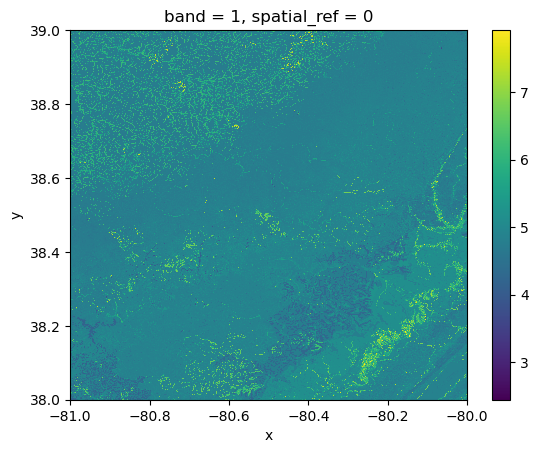

In [26]:
GWNF_soil_data[3].plot()

# Elevation Data
Elevation from the SRTM (available from the earthaccess API)

In [3]:
# data_dir = os.path.join(
#     # Home directory
#     pathlib.Path.home(),
#     # Earth analytics data directory
#     'earth-analytics',
#     'data',
#     # Project directory
#     'habitat-suitability',
# )

elevation_dir = os.path.join(data_dir, 'srtm')

os.makedirs(elevation_dir, exist_ok=True)

In [4]:
earthaccess.login()

In [5]:
datasets = earthaccess.search_datasets(keyword='SRTMGL1')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])


SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL1N NASA Shuttle Radar Topography Mission Global 1 arc second number V003
SRTMGL1_NUMNC NASA Shuttle Radar Topography Mission Global 1 arc second Number NetCDF V003
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003


In [6]:
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')
if not glob(srtm_pattern):
    bounds = tuple(GWNF_gdf.total_bounds)
    buffer = .025
    xmin, ymin, xmax, ymax = bounds
    bounds_buffer = (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
    srtm_results = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=bounds_buffer
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

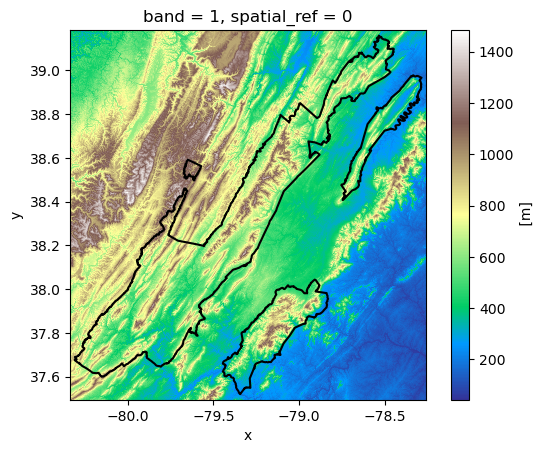

In [7]:
srtm_da_list = []

for srtm_path in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(cropped_da)


srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap='terrain')
GWNF_gdf.boundary.plot(ax=plt.gca(), color='black')


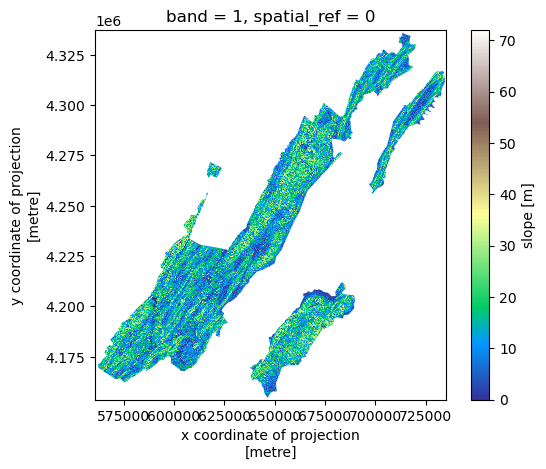

In [ ]:
# Reproject so units are in meters
epsg_utm17n = 32617
srtm_proj_da = srtm_da.rio.reproject(epsg_utm17n)
GWNF_proj_gdf = GWNF_gdf.to_crs(epsg_utm17n)
bounds_proj = tuple(GWNF_proj_gdf.total_bounds)

# Calculate rsxspatial.slope or .aspect
slope_full_da = xrspatial.slope(srtm_proj_da)
#slope_da = slope_full_da.rio.clip_box(*bounds_proj)
slope_da = slope_full_da.rio.clip(GWNF_proj_gdf.geometry)

# Plot slope
slope_da.plot(cmap='terrain')
GWNF_proj_gdf.boundary.plot(ax=plt.gca(), color='white')
plt.show()

# Climate Data
At least one climate variable from the MACAv2 THREDDS data server. Your project should compare two climate scenarios of your choice (e.g. different time periods, different emission scenarios). You can find a tutorial on how to access these climate data on earthdatascience.org